# Capstone 2023 - Brain Tumor MRI Classification Convolutional Neural Network

In [ ]:
# only for google colab use
# import google drive
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install keras-tuner

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
# import libraries
import numpy as np
from PIL import Image, ImageEnhance
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pydot
import random
import networkx as nx

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Add, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
from keras_tuner import Objective, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [ ]:
# print libraries version
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('tensorflow version: ', tf.__version__)
print('cv2 version: ', cv2.__version__)
print('seaborn version: ', sns.__version__)

from platform import python_version
print('python version: ', python_version())

numpy version:  1.24.3
pandas version:  2.1.1
tensorflow version:  2.13.1
cv2 version:  4.8.1
seaborn version:  0.13.0
python version:  3.10.12


In [ ]:
# set batch size, image size
batch_size = 32
image_size= 150
le=LabelEncoder()
# set the labels
labels=['glioma', 'meningioma', 'notumor', 'pituitary']

# Path initialization

In [ ]:
# data preparation
# set the path to the data directory
data_dir = os.path.join(os.getcwd())
# set the path to the training directory
train_dir = os.path.join(data_dir, 'Training')
# set the path to the testing directory
test_dir = os.path.join(data_dir, 'Testing')

print(data_dir)
print(train_dir)
print(test_dir)

g:\My Drive\Data\CAPSTONE\Brain tumor 3
g:\My Drive\Data\CAPSTONE\Brain tumor 3\Training
g:\My Drive\Data\CAPSTONE\Brain tumor 3\Testing


In [ ]:
# data preparation for google colab
# set the path to the data directory
# data_dir = ('/content/drive/My Drive/Data/CAPSTONE/Brain tumor 3/')
# set the path to the training directory
# train_dir = ('/content/drive/My Drive/Data/CAPSTONE/Brain tumor 3/Training')
# set the path to the testing directory
# test_dir = ('/content/drive/My Drive/Data/CAPSTONE/Brain tumor 3/Testing')

print(data_dir)
print(train_dir)
print(test_dir)

/content/drive/My Drive/Data/CAPSTONE/Brain tumor 3/
/content/drive/My Drive/Data/CAPSTONE/Brain tumor 3/Training
/content/drive/My Drive/Data/CAPSTONE/Brain tumor 3/Testing


In [ ]:
# Check if the directory works
for label in labels:
    print('{}: {} images'.format(label, len(os.listdir(os.path.join(train_dir, label)))))

glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


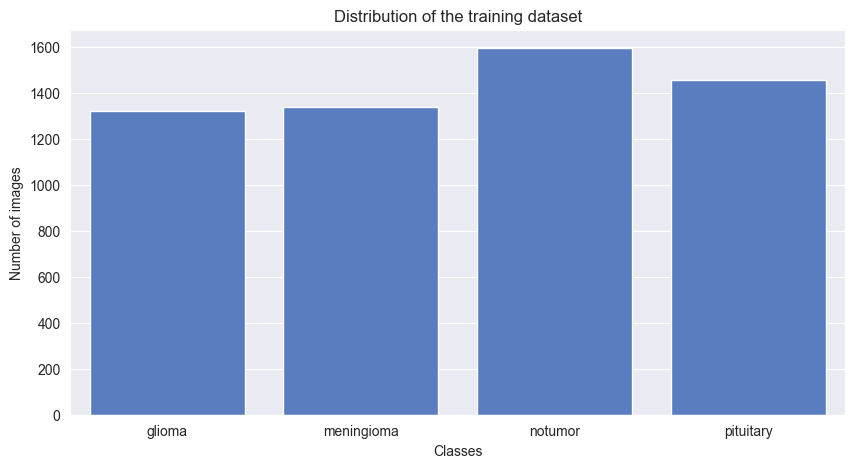

In [ ]:
# plot the distribution of the training dataset
sns.set_style('darkgrid')
sns.set_palette('muted')
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=[len(os.listdir(os.path.join(train_dir, label))) for label in labels])
plt.title('Distribution of the training dataset')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.show()

## Fairly balanced dataset ##

In [ ]:
# print number of samples images per class
for label in labels:
    print('{}: {} images'.format(label, len(os.listdir(os.path.join(test_dir, label)))))

glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images


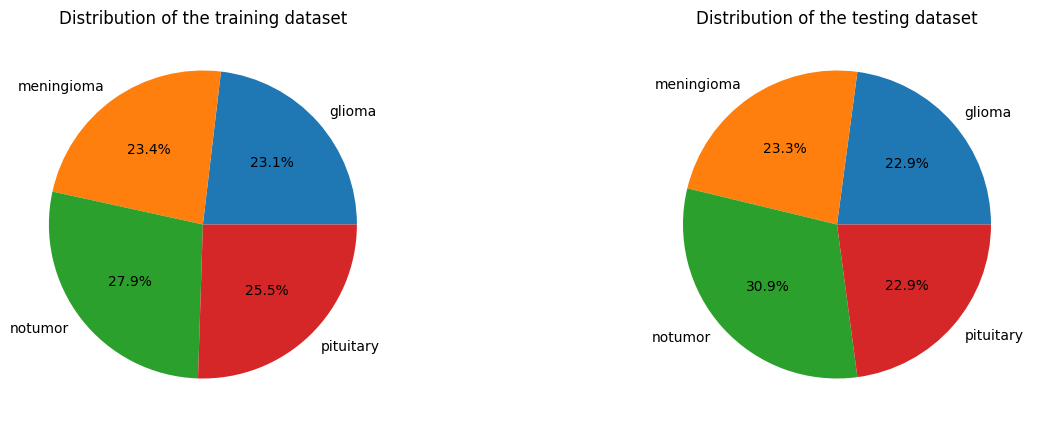

In [ ]:
# plot a pie chart of the distribution of training and testing dataset
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.pie([len(os.listdir(os.path.join(train_dir, label))) for label in labels], labels=labels, autopct='%1.1f%%')
plt.title('Distribution of the training dataset')
plt.subplot(1, 2, 2)
plt.pie([len(os.listdir(os.path.join(test_dir, label))) for label in labels], labels=labels, autopct='%1.1f%%')
plt.title('Distribution of the testing dataset')
plt.show()

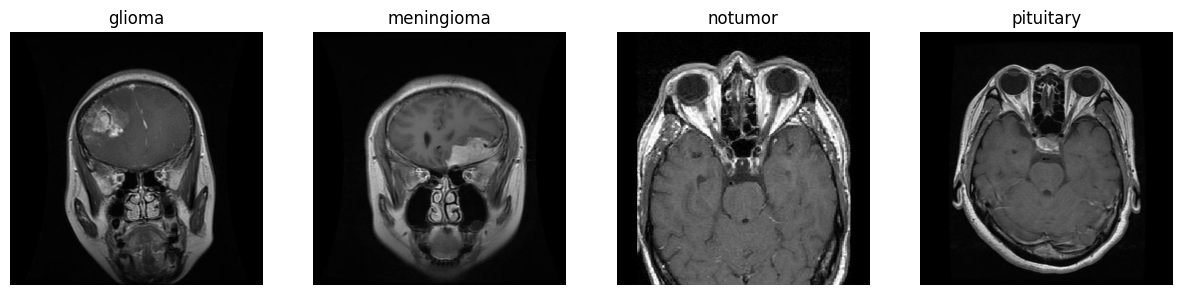

In [ ]:
# show random images from each class
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
for i, label in enumerate(labels):
    ax[i].imshow(plt.imread(os.path.join(train_dir, label, os.listdir(os.path.join(train_dir, label))[0])))
    ax[i].set_title(label)
    ax[i].axis('off')

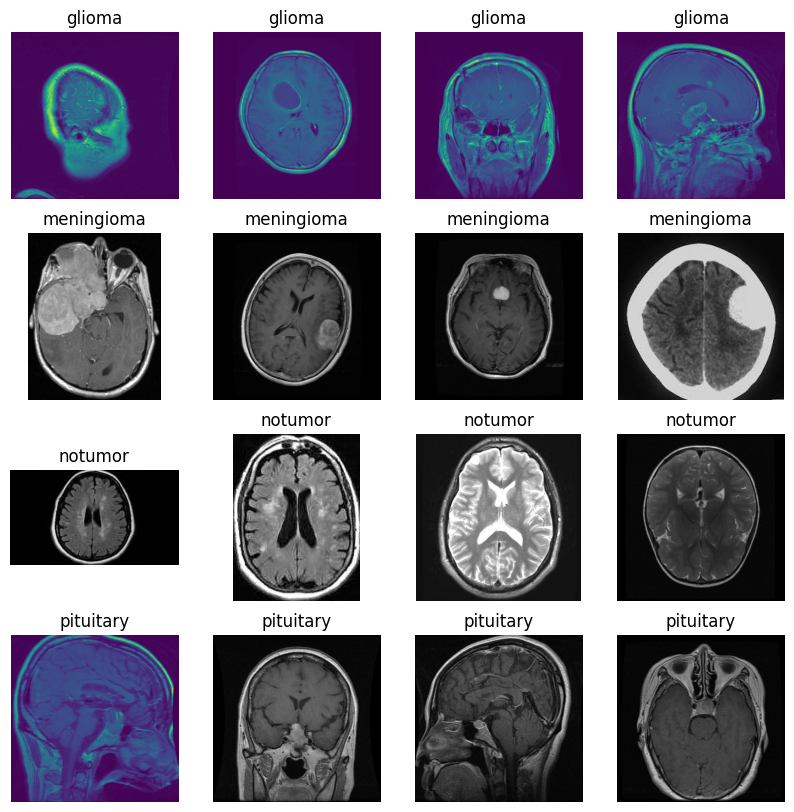

In [ ]:
# show 12 random images from the training dataset
plt.figure(figsize=(10, 10))
for i, label in enumerate(labels):
    for j in range(4):
        plt.subplot(4, 4, 4*i+j+1)
        plt.imshow(plt.imread(os.path.join(train_dir, label, os.listdir(os.path.join(train_dir, label))[random.randint(0, len(os.listdir(os.path.join(train_dir, label))))])))
        plt.title(label)
        plt.axis('off')

In [ ]:
# define image augmentation
def img_aug(image):
    # convert image to array
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.5, 1.5))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.5, 1.5))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.5, 1.5))
    image = np.array(image)/255
    return image

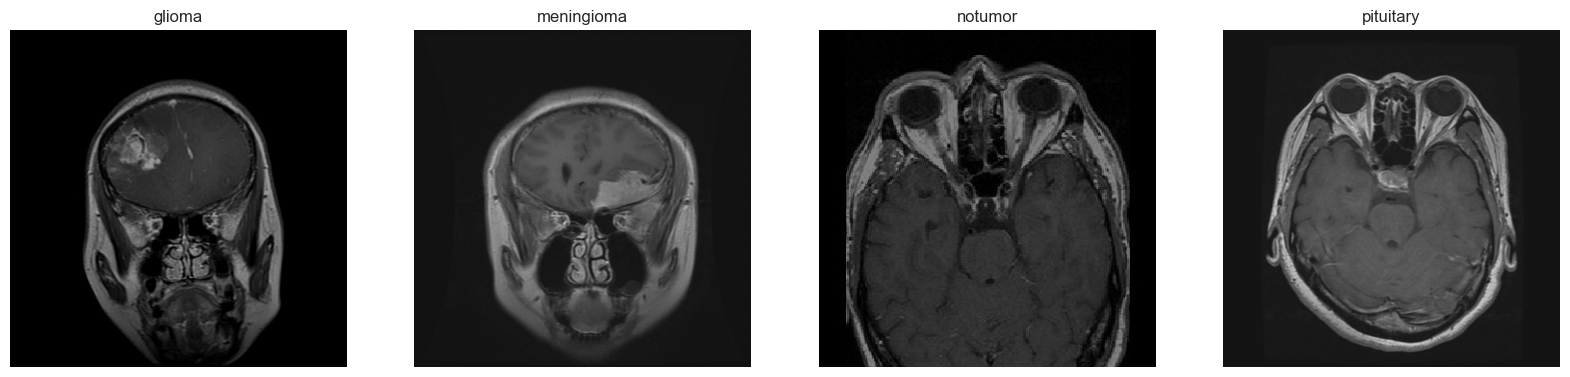

In [ ]:
# show the augmented images
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for i, label in enumerate(labels):
    ax[i].imshow(img_aug(plt.imread(os.path.join(train_dir, label, os.listdir(os.path.join(train_dir, label))[0]))))
    ax[i].set_title(label)
    ax[i].axis('off')

In [ ]:
# itterate training dataset, apply resizing, augmentation and convert to array
X_train = [] # set the list
y_train = []
for label in labels:
    for image in tqdm(os.listdir(os.path.join(train_dir, label))):
        path = os.path.join(train_dir, label, image)
        # read the image
        image = cv2.imread(path)
        # resize the image
        image = cv2.resize(image, (image_size, image_size))
        # convert image to array
        image = np.array(image)
        # apply image augmentation
        image = img_aug(image)
        # append the image and its corresponding label to the train_data list
        X_train.append(image)
        y_train.append(label)

# enconde the labels
y_train = le.fit_transform(y_train)

# shuffle the training data to avoid bias
train_data = list(zip(X_train, y_train))
random.shuffle(train_data)

# convert train_data to a numpy array
X_train, y_train = zip(*train_data)
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1457/1457 [00:26<00:00, 54.02it/s] 


In [ ]:
# itterate test images and turn them into numpy array
X_test = []
y_test = []
for label in labels:
    for image in tqdm(os.listdir(os.path.join(test_dir, label))):
        path = os.path.join(test_dir, label, image)
        # read the image
        image = cv2.imread(path)
        # resize the image
        image = cv2.resize(image, (image_size, image_size))
        # convert image to array
        image = np.array(image)
        # normalize the image
        image = image/255
        # append the image and its corresponding label to the test_data list
        X_test.append(image)
        y_test.append(label)

# enconde the labels
y_test = le.fit_transform(y_test)

# convert test_data to a numpy array
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 300/300 [00:05<00:00, 59.56it/s] 


In [ ]:
# save the train and test data for quick load purposes
np.save('X_train_at2', X_train)
np.save('y_train_at2', y_train)
np.save('X_test_at2', X_test)
np.save('y_test_at2', y_test)

In [ ]:
# print the shape of the arrays
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (5712, 150, 150, 3)
y_train shape:  (5712,)
X_test shape:  (1311, 150, 150, 3)
y_test shape:  (1311,)


In [ ]:
# load the arrays
X_train = np.load('X_train_at2.npy')
y_train = np.load('y_train_at2.npy')
X_test = np.load('X_test_at2.npy')
y_test = np.load('y_test_at2.npy')

In [ ]:
# perform one hot encoding on the labels to match the number of labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# print the shape of y_train and y_test
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

y_train shape:  (5712, 4)
y_test shape:  (1311, 4)


## 1st Model Building ##

In [ ]:
# define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3))) # first layer of the model contains 32 filters with 3x3 kernel size.
model.add(MaxPooling2D((2, 2))) # max pooling layer with 2x2 pool size. This layer reduces the size of the feature maps by half.
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten()) # flatten layer to stack the output convolutions from second convolution layer. This prepares the data for the fully connected layers.
model.add(Dense(128, activation='relu')) # fully connected layer with 128 neurons.
model.add(Dense(4, activation='softmax')) # output layer with 4 neurons for 4 classes. Softmax activation function is used for multi-class classification.

# print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 147968)           

In [ ]:
# compile the model with different metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), 'accuracy'])

# define early stopping
early_stop = EarlyStopping(monitor='accuracy', patience=5)

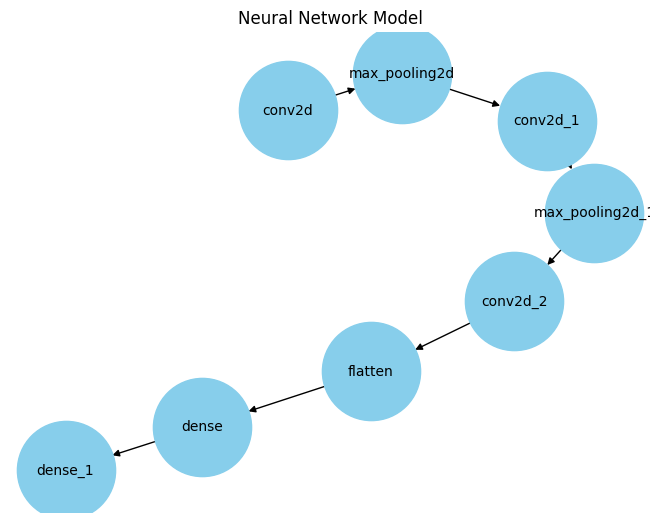

In [ ]:
# visualize model network to help with the blackbox
G= nx.DiGraph()

# define the order of layers
layer_order = ['conv2d', 'max_pooling2d', 'flatten', 'dense']

# add nodes to the graph
for layer_name in layer_order:
    G.add_node(layer_name)

# add edges to the graph
for i in range(len(model.layers)-1):
    G.add_edge(model.layers[i].name, model.layers[i+1].name)

# add layout
pos = nx.spring_layout(G, seed=24)

# draw the graph
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10)
plt.title("Neural Network Model")
plt.show()

In [ ]:
# fit the model
history_simple = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
179/179 [==============================] - 13s 13ms/step - loss: 0.8274 - auc: 0.8921 - recall: 0.5532 - precision: 0.7683 - accuracy: 0.6793
Epoch 2/50
179/179 [==============================] - 2s 12ms/step - loss: 0.4427 - auc: 0.9645 - recall: 0.8016 - precision: 0.8554 - accuracy: 0.8340
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 0.2859 - auc: 0.9841 - recall: 0.8831 - precision: 0.9041 - accuracy: 0.8948
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 0.1748 - auc: 0.9932 - recall: 0.9359 - precision: 0.9450 - accuracy: 0.9401
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 0.0971 - auc: 0.9977 - recall: 0.9680 - precision: 0.9705 - accuracy: 0.9694
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 0.0549 - auc: 0.9988 - recall: 0.9811 - precision: 0.9823 - accuracy: 0.9820
Epoch 7/50
179/179 [==============================] - 2s 12ms/step - loss: 0.0502 - auc

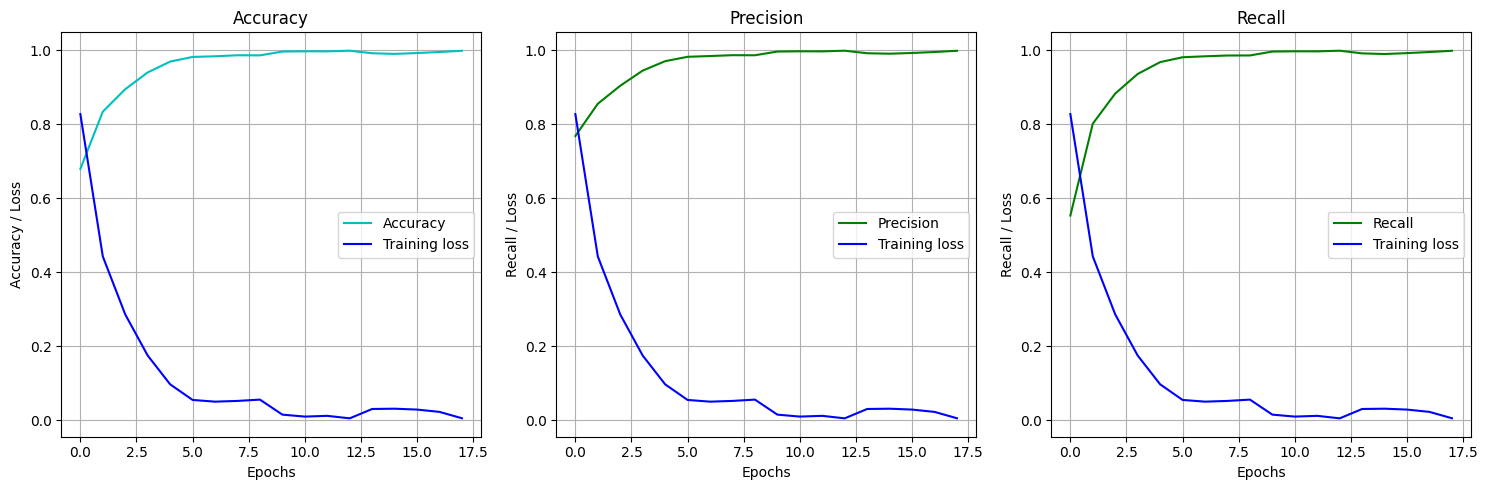

In [ ]:
# plot the training history
plt.figure(figsize=(15,5))

# Subplot 1: Accuracy and Training Loss
plt.subplot(1, 3, 1)
plt.plot(history_simple.history['accuracy'], 'c', label='Accuracy')
plt.plot(history_simple.history['loss'], 'b', label='Training loss')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.grid(True)
plt.legend()

# Subplot 3: Recall and Training Loss
plt.subplot(1, 3, 3)
plt.plot(history_simple.history['recall'], 'g', label='Recall')
plt.plot(history_simple.history['loss'], 'b', label='Training loss')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall / Loss')
plt.grid(True)
plt.legend()

# Subplot 4: Precision and Training Loss
plt.subplot(1, 3, 2)
plt.plot(history_simple.history['precision'], 'g', label='Precision')
plt.plot(history_simple.history['loss'], 'b', label='Training loss')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Recall / Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# evaluate the model on the test dataset
model.evaluate(X_test, y_test)

41/41 [==============================] - 1s 9ms/step - loss: 0.2345 - auc: 0.9898 - recall: 0.9626 - precision: 0.9626 - accuracy: 0.9626


[0.23454320430755615,
 0.989837646484375,
 0.9626239538192749,
 0.9626239538192749,
 0.9626239538192749]

In [ ]:
# print the classification report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

41/41 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       300
           1       0.93      0.92      0.92       306
           2       1.00      1.00      1.00       405
           3       0.98      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [ ]:
# save the model
model.save('/content/drive/My Drive/Data/Capstone/Brain tumor 3/Final Model 2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


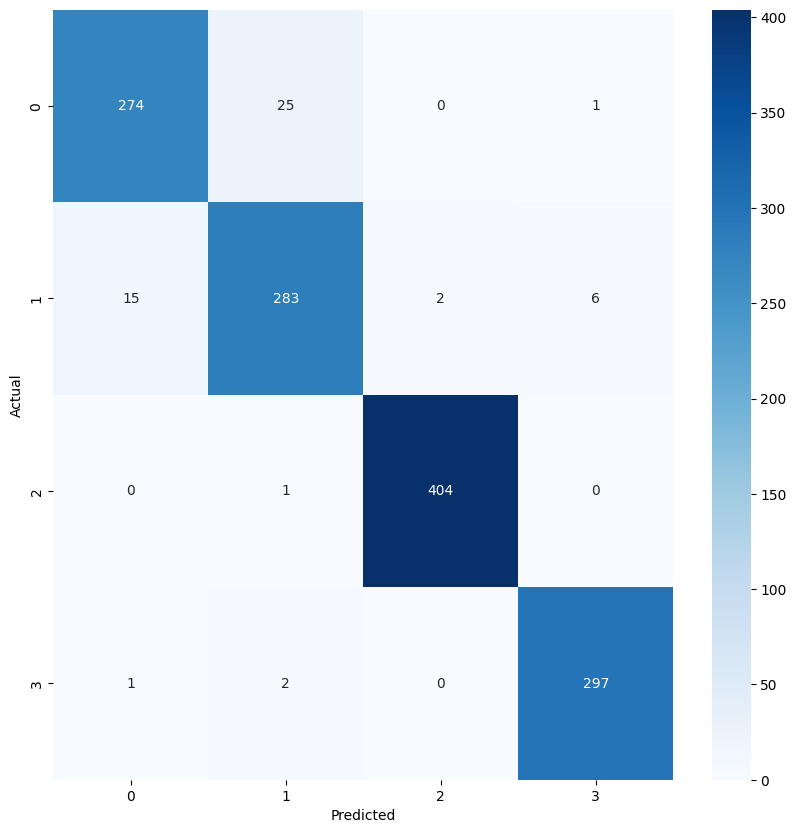

In [ ]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

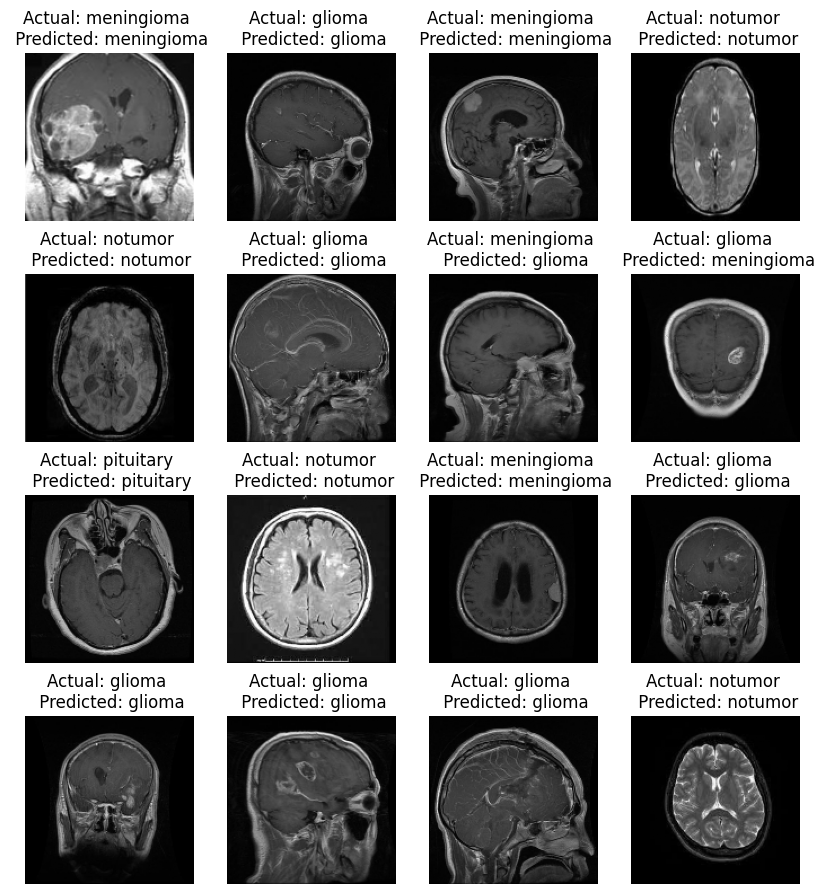

In [ ]:
# show images with predicted and actual labels
fig, ax = plt.subplots(4, 4, figsize=(10, 11))
for i in range(4):
    for j in range(4):
        index = random.randint(0, len(X_test))
        ax[i, j].imshow(X_test[index])
        ax[i, j].set_title('Actual: {} \n Predicted: {}'.format(labels[np.argmax(y_test[index])], labels[y_pred[index]]))
        ax[i, j].axis('off')

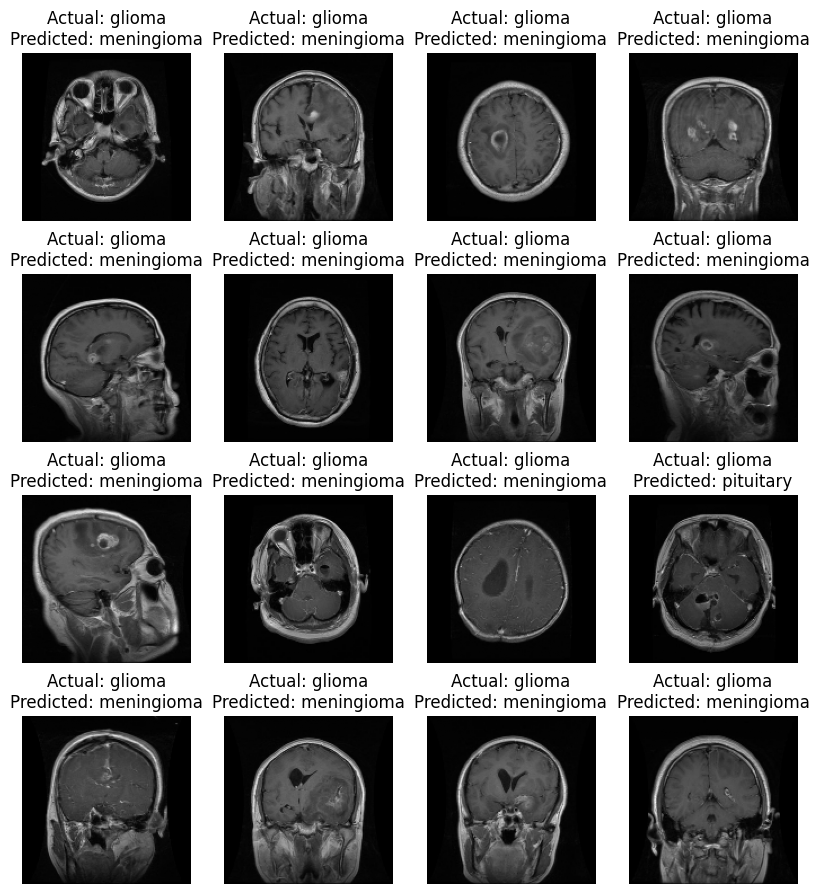

In [ ]:
# showing misdiagnosed_images
misdiagnosed_images = []

# Find misdiagnosed images and store them in the misdiagnosed_images list
for i in range(len(X_test)):
    if np.argmax(y_test[i]) != y_pred[i]:
        misdiagnosed_images.append((X_test[i], labels[np.argmax(y_test[i])], labels[y_pred[i]]))

# Display the misdiagnosed images in a grid
fig, axes = plt.subplots(4, 4, figsize=(10, 11))
for i in range(4):
    for j in range(4):
        if i * 4 + j < len(misdiagnosed_images):
            image, actual_label, predicted_label = misdiagnosed_images[i * 4 + j]
            ax = axes[i, j]
            ax.imshow(image)
            ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
            ax.axis('off')

plt.show()

## Hyperparameter tuning

In [ ]:
# tune the hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp.Int('conv_3_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the tuner
tuner = RandomSearch(
    build_model,
    objective=Objective('val_accuracy', direction='max'),
    max_trials=2,
    executions_per_trial=3,
    directory='model_tuner',
    project_name='brain_tumor'
)

In [ ]:
# search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, batch_size=32,  callbacks=[early_stop])

Trial 2 Complete [00h 03m 39s]

Best val_accuracy So Far: None
Total elapsed time: 00h 07m 58s


In [ ]:
# get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# print the best hyperparameters
best_model.get_config()

# print the best model summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 112)     3136      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 112)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 48)        48432     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 48)        20784     
                                                                 
 flatten (Flatten)           (None, 55488)             0

In [ ]:
# evaluate the best model on the test dataset
loss, accuracy = best_model.evaluate(X_test, y_test)

41/41 [==============================] - 1s 11ms/step - loss: 0.2677 - accuracy: 0.9436


In [ ]:
# print the classification report
y_pred_tuned = best_model.predict(X_test)
y_pred_tuned = np.argmax(y_pred_tuned, axis=1)

print('Test loss: ', loss)
print('Test accuracy: ', accuracy)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

41/41 [==============================] - 0s 6ms/step
Test loss:  0.26769351959228516
Test accuracy:  0.9435545206069946
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       300
           1       0.92      0.92      0.92       306
           2       0.99      1.00      0.99       405
           3       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



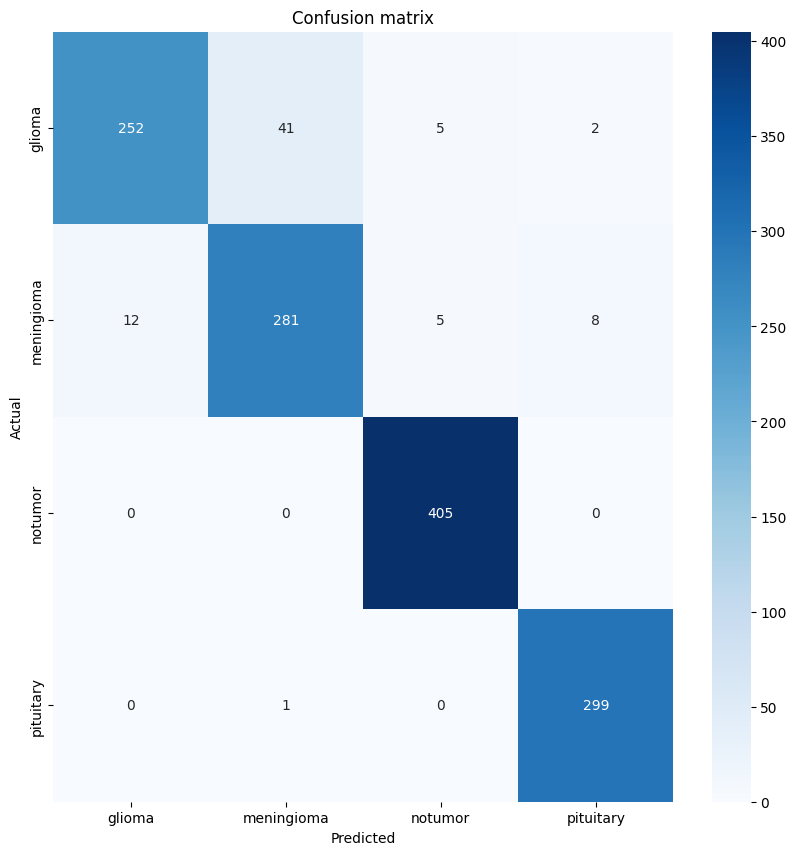

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_tuned)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [ ]:
# save the best model
best_model.save('model_best_at2.h5')

c:\Users\GGPC\Anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Tuned model does not improve the model, stick to first model